In [1]:
from datetime import datetime

print()
start = datetime.now()
print(f'Start Time : {start}')


Start Time : 2023-03-24 12:42:05.519501


In [2]:
from tabascal.optimize.mcmc import inv_kernel_vmap, inv_kernel, log_normal, log_multinorm, log_multinorm_sum
from tabascal.jax.coordinates import orbit
from tabascal.utils.tools import progress_bar_scan

from jax import random, jit, vmap, jacrev
import jax.numpy as jnp

from jax.flatten_util import ravel_pytree as flatten
from jax.lax import scan

from jax.tree_util import tree_map
import jax

from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import h5py

plt.rcParams['font.size'] = 16

In [3]:
import xarray as xr 

In [12]:
flux = jnp.logspace(-3, 0, 101)  
dN_df = 10**3.75 * flux**-1.6

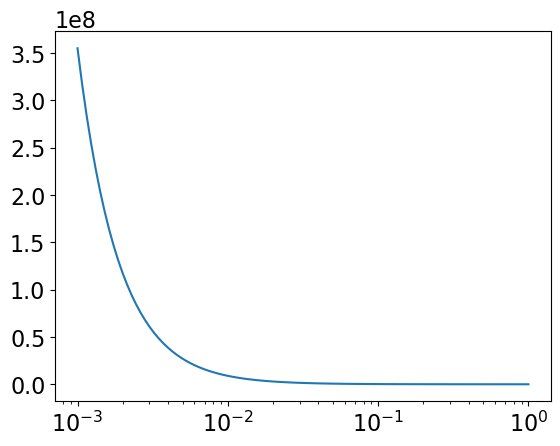

In [13]:
plt.semilogx(flux, dN_df)

In [14]:
0.2/8000

2.5e-05

In [3]:
import astropy.constants as c
import astropy.units as u

In [29]:
8e3*u.m/(0.2*u.m) * np.sqrt( c.GM_earth / (c.R_earth+20.2e6*u.m)**3 )

<Quantity 5.82831425 1 / s>

In [109]:
8e3*u.m/(0.2*u.m) * np.sqrt( c.GM_earth / (c.R_earth+800e3*u.m)**3 )

<Quantity 41.52547414 1 / s>

In [110]:
8e3*u.m/(0.2*u.m) * np.sqrt( c.GM_earth / (c.R_earth+400e3*u.m)**3 )

<Quantity 45.25503432 1 / s>

In [159]:
(2*c.k_B*(1/(400*u.m**2/u.K))).to(u.Jy), (2*c.k_B*(1/(500*u.m**2/u.K))).to(u.Jy)

(<Quantity 6.903245 Jy>, <Quantity 5.522596 Jy>)

In [10]:
import numpy as np

In [11]:
(2*c.k_B*(1/(1.7*u.m**2/u.K))).to(u.Jy)/np.sqrt(250)

<Quantity 102.72930563 Jy>

In [15]:
np.deg2rad(0.02)/1e8

3.490658503988659e-12

In [126]:
xs = [0.3+np.arange(0, 2*np.pi, 2*np.pi/i) for i in np.arange(2, 100, 0.1)]
ys = [np.cos(x) for x in xs] 
ys_int = [np.abs(np.mean(y)) for y in ys]
ns = [len(x) for x in xs]

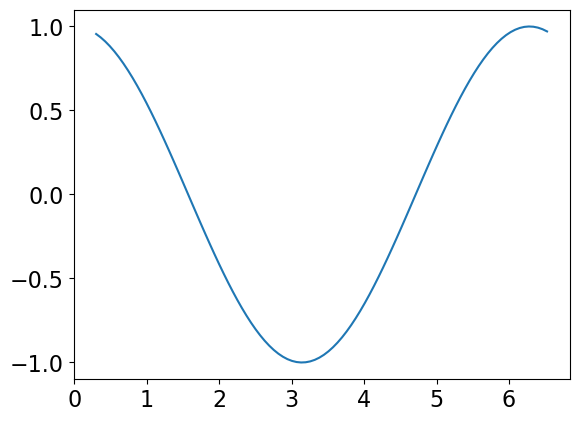

In [127]:
plt.plot(xs[-1], ys[-1])

(0.001, 1)

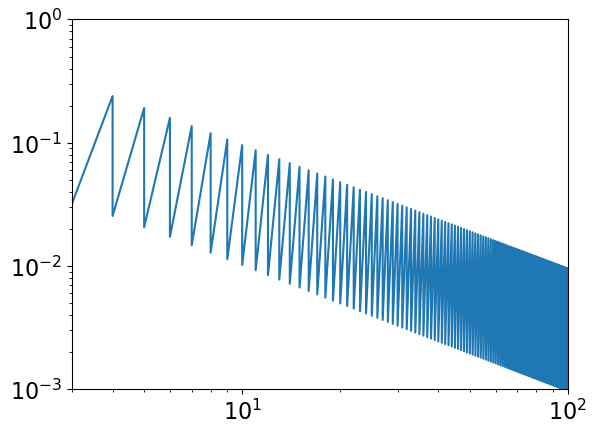

In [132]:
plt.loglog(ns, ys_int)
# plt.semilogy(ns, ys_int)
plt.xlim(3, 100)
plt.ylim(1e-3, 1)
# plt.xlim(60,65)

<function matplotlib.pyplot.xlim(*args, **kwargs)>

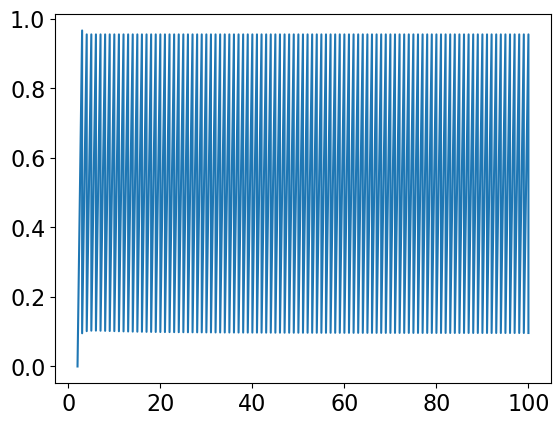

In [129]:
plt.plot(ns, np.array(ns)*np.array(ys_int))
plt.xlim

In [4]:
f_name = "/Users/chrisfinlay/Documents/PhD/tabascal/tabascal/tabascal/examples/test_obs_64A_450T_128I_001F_100AST_1SAT_0GRD/"
# f_name = "/Users/chrisfinlay/Documents/PhD/tabascal/tabascal/tabascal/examples/test_obs_64A_450T_128I_001F_100AST_2SAT_0GRD/"

In [6]:
def get_obs_info(ds_file_path, baseline, sampling):
    ds = xr.open_zarr(ds_file_path)
    
    a1 = ds.antenna1.data.compute()[baseline]
    a2 = ds.antenna2.data.compute()[baseline]
    ants = np.array([a1, a2])
    
    ds_info = {
        'N_int_samples': ds.attrs["n_int_samples"]//sampling,
        'N_ant': 2,
        'N_bl': 1,
        'N_time': ds.attrs["n_time"],
        'times': ds.coords["time"].data,
        'times_fine': ds.coords["time_fine"].data[::sampling],
        'bl_uvw': ds.bl_uvw.data.compute()[::sampling, baseline],
        'ants_uvw': ds.ants_uvw.data.compute()[::sampling, ants],
        'ants_xyz': ds.ants_xyz.data.compute()[::sampling, ants],
        'vis_ast': ds.vis_ast.data.compute()[::sampling, baseline, 0],
        'vis_rfi': ds.vis_rfi.data.compute()[::sampling, baseline, 0],
        'vis_obs': ds.vis_obs.data.compute()[:, baseline, 0],
        'noise': ds.noise_std.data.compute(),
        'int_time': ds.attrs["int_time"],
        'freqs': ds.coords["freq"].data,
        'gains_ants': ds.gains_ants.data.compute()[::sampling, ants, 0],
        'rfi_A_app': ds.rfi_sat_A.data.compute()[:, ::sampling, ants, 0],
        'rfi_orbit': ds.rfi_sat_orbit.data.compute()[:],
    }
    
    ds.close()
    
    return ds_info

In [7]:
baseline = 0
# baseline = 1867
# baseline = 1380
sampling = 1

ds = get_obs_info(f_name, baseline, sampling) 

In [20]:
209e3*128/1e6

26.752

In [19]:
(1.2e9+209e3*128)/1e9

1.226752

In [8]:
np.sqrt(15*3600/2*3680)

9967.94863550169

In [165]:


a1 = ds.antenna1.data.compute()[baseline]
a2 = ds.antenna2.data.compute()[baseline]
ants = jnp.array([a1, a2])

N_int_samples = ds.attrs["n_int_samples"]//sampling
N_ant = 2 # ds.attrs["n_ant"]
N_bl = 1 # ds.attrs["n_bl"]
N_time = ds.attrs["n_time"]
times = ds.coords["time"].data
times_fine = ds.coords["time_fine"].data[::sampling]
bl_uvw = ds.bl_uvw.data.compute()[::sampling, baseline]
ants_uvw = ds.ants_uvw.data.compute()[::sampling, ants]
ants_xyz = ds.ants_xyz.data.compute()[::sampling, ants]
vis_ast = ds.vis_ast.data.compute()[::sampling, baseline, 0]
vis_rfi = ds.vis_rfi.data.compute()[::sampling, baseline, 0]
vis_obs = ds.vis_obs.data.compute()[:, baseline, 0]
noise = ds.noise_std.data.compute()
int_time = ds.attrs["int_time"]
freqs = ds.coords["freq"].data
gains_ants = ds.gains_ants.data.compute()[::sampling, ants, 0]
rfi_A_app = ds.rfi_sat_A.data.compute()[:, ::sampling, ants, 0]
rfi_orbit = ds.rfi_sat_orbit.data.compute()[:]

In [13]:
bl_uvw = ds['bl_uvw']
times_fine = ds['times_fine']

In [16]:
n_int = ds['N_int_samples']
bl_uvw_coarse = bl_uvw[n_int//2::n_int]

In [14]:
uvw = 

128

In [166]:
print(f'Baseline length : {jnp.linalg.norm(bl_uvw[0]):.0f} m')

Baseline length : 860 m


In [283]:
theta = jnp.deg2rad(rfi_orbit[0,1])
h = rfi_orbit[0,0]

omega = jnp.sqrt(c.GM_earth/(c.R_earth+h*u.m)**3)
u_s = omega*jnp.cos(theta)
v_s = omega*jnp.sin(theta)
w_s = jnp.sqrt((1/jnp.diff(times_fine)[0]**2)-u_s**2-v_s**2)
w_s = 0

uv_s = jnp.array([u_s, v_s, w_s])

lam = jnp.array(c.c/freqs)
uv_pq = bl_uvw[:,:3]/lam

In [284]:
from tabascal.jax.coordinates import T_s
natural_fringe = -2*jnp.pi/T_s*bl_uvw[:,0]/lam*jnp.cos(jnp.deg2rad(ds.attrs['target_dec']))

In [342]:
fringe_freq = uv_s@uv_pq.T - natural_fringe
fringes = fringe_freq*jnp.diff(times_fine)[0] #- uv_pq[:,-1]/lam - 7800

In [384]:
vis_fringes = jnp.unwrap(jnp.angle(vis_rfi), discont=0.0, axis=0)/(2*jnp.pi)
f_freq = jnp.diff(vis_fringes)/jnp.diff(times_fine)[0]
f_freq  = jnp.where(f_freq>5, -0.1, f_freq)

vis_fringes2 = jnp.unwrap(2*jnp.arctan(vis_rfi.imag/vis_rfi.real), discont=0.0)/(4*jnp.pi)
f_freq2 = jnp.diff(vis_fringes2)/jnp.diff(times_fine)

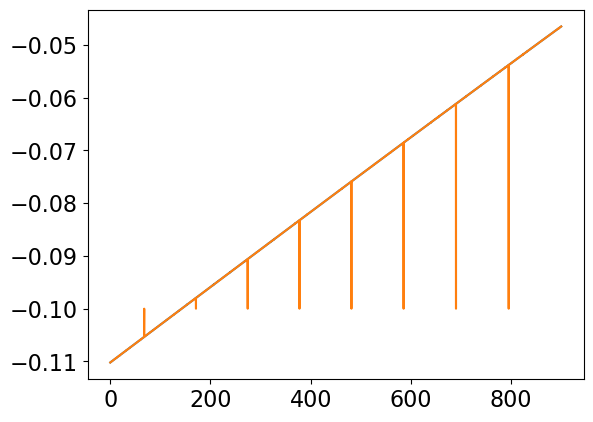

In [385]:
plt.plot(times_fine[1:]-times_fine[1], f_freq2)
plt.plot(times_fine[1:]-times_fine[1], f_freq)

(0.0, 15.0)

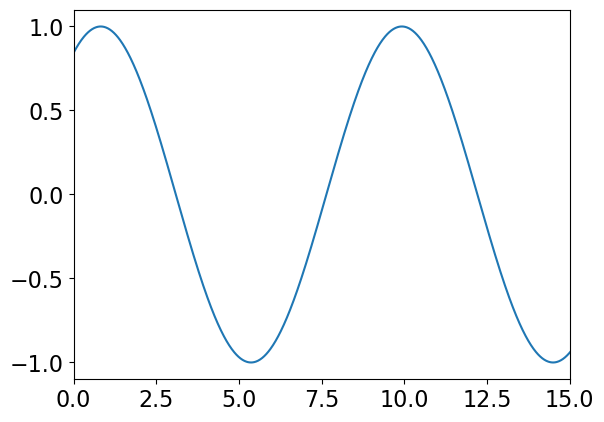

In [387]:
plt.plot(times_fine-times_fine[0], vis_rfi.real/jnp.abs(vis_rfi))
plt.xlim(0, 15)

(870.0, 900.0)

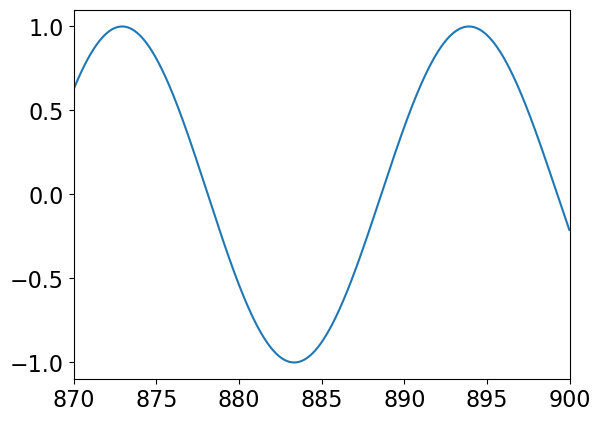

In [386]:
plt.plot(times_fine-times_fine[0], vis_rfi.real/jnp.abs(vis_rfi))
plt.xlim(870, 900)

In [7]:
from tabascal.jax.interferometry import ants_to_bl
gains_bl = ants_to_bl(gains_ants.reshape(N_time, -1, N_ant, 1).mean(axis=1), 0, 1)[...,0]

v_ast = vis_ast.reshape(N_time,-1).mean(axis=1)

v_cal = vis_obs/gains_bl

flags = jnp.where(jnp.abs(v_ast-v_cal)>3*noise, True, False)

print(f'Mean RFI Amp. : {jnp.mean(jnp.abs(vis_rfi.reshape(N_time,-1).mean(axis=1))):.0f} Jy\nFlag Rate :     {100*flags.mean():.2f} %')

Mean RFI Amp. : 160 Jy
Flag Rate :     100.00 %


In [8]:
print()
print(f'Number of Antennas: {N_ant}')
print()
print(f'Number of Time Steps: {N_time}')


Number of Antennas: 2

Number of Time Steps: 450


In [9]:
@jit
def kernel(x, x_, var, l, noise=1e-3):
    '''
    x: array (n_points, n_dim)
    '''
    x = x[:,None] if x.ndim==1 else x
    x_ = x_[:,None] if x_.ndim==1 else x_
    chi = jnp.linalg.norm(x[None,:,:]-x_[:,None,:], axis=-1) / l
    cov = jnp.abs(var)*jnp.exp(-0.5*chi**2)
    if chi.shape[0]==chi.shape[1]:
        cov += noise*jnp.eye(x.shape[0])
    return cov

@jit
def resampling_kernel(x, x_, var, l, noise=1e-3):
    K_inv = jnp.linalg.inv(kernel(x, x, var, l, noise))
    K_s = kernel(x, x_, var, l)
    return K_s@K_inv

In [10]:
@jit
def gp_resample(y, x, x_, var, l, noise=1e-3):
    K_inv = jnp.linalg.inv(kernel(x, x, var, l, noise))
    K_s = kernel(x, x_, var, l)
    return K_s@K_inv@y

@jit
def resampled_cov(x, x_, var, l, noise_cov):
    K = kernel(x, x, var, l, 1e-3)
    K_inv = jnp.linalg.inv(K + noise_cov)
    K_s = kernel(x, x_, var, l)
    K_ss = kernel(x_, x_, var, l)
    return K_ss - K_s@K_inv@K_s.T

In [11]:
def l_from_uv(uv, l0=7e2, a=3e3):
    return l0*jnp.exp(-uv/a)

def get_times(gp_l, times):
    
    int_time = times[1] - times[0]
    t_i = times[0] - int_time/2
    t_f = times[-1] + int_time/2
    n_vis_times = jnp.ceil(2. * ((t_f - t_i)/gp_l) + 1).astype(int)
    vis_times = jnp.linspace(t_i, t_f, n_vis_times)
    
    return vis_times

def fringe_phasor(w, freq):
    
    from tabascal.jax.interferometry import c
    phasor = jnp.exp(-2.j*jnp.pi*freq/c*w)
    
    return phasor

def derotated_vis_phase(vis, w, freq):
    
    derotated_vis = vis*fringe_phasor(w, freq)
    phase = jnp.unwrap(jnp.angle(derotated_vis), discont=0.0)
    
    return phase

def derotated_vis(vis, w, freq):
    
    return vis*fringe_phasor(w, freq)


scalings = {'g_amp': jnp.array([100.]),
            'g_phase': jnp.rad2deg(1.),
            'rfi_orbit': jnp.diag(jnp.array([1e-2, 3600e0, 3600e1, 3600e1]))}

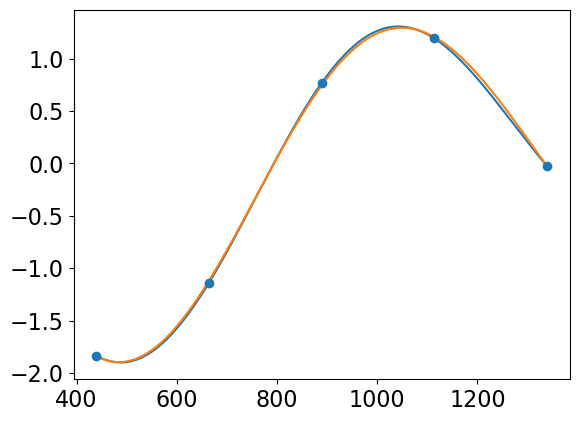

In [12]:
mag_uvw = jnp.linalg.norm(bl_uvw[0], axis=-1)
ast_l = l_from_uv(mag_uvw, l0=7e2, a=2.5e3)
ast_var = (jnp.abs(vis_ast).max(axis=(0)) + noise)**2

ast_times = get_times(ast_l, times)

resample_ast = resampling_kernel(ast_times, times, ast_var, ast_l)

ast_real = jnp.interp(ast_times, times_fine, vis_ast.real)
ast_imag = jnp.interp(ast_times, times_fine, vis_ast.imag)

plt.plot(times_fine, vis_ast.real)
plt.plot(times, resample_ast@ast_real)
plt.plot(ast_times, ast_real, 'o', color='tab:blue');

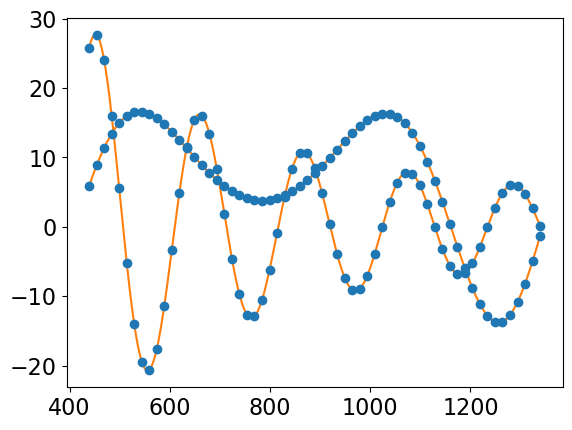

In [13]:
rfi_var, rfi_l = 1.0e3, 30.

rfi_times = get_times(rfi_l, times)

resample_rfi = resampling_kernel(rfi_times, times_fine, rfi_var, rfi_l, noise=1e-4)

rfi_A = vmap(vmap(jnp.interp, in_axes=(None,None,1), out_axes=(1)), in_axes=(None,None,0), out_axes=(0))(rfi_times, times_fine, rfi_A_app)

plt.plot(times_fine, rfi_A_app[:,:,0].T, color='tab:orange')
plt.plot(rfi_times, rfi_A[:,:,0].T, 'o', color='tab:blue');

Text(0, 0.5, 'Gain Amplitude')

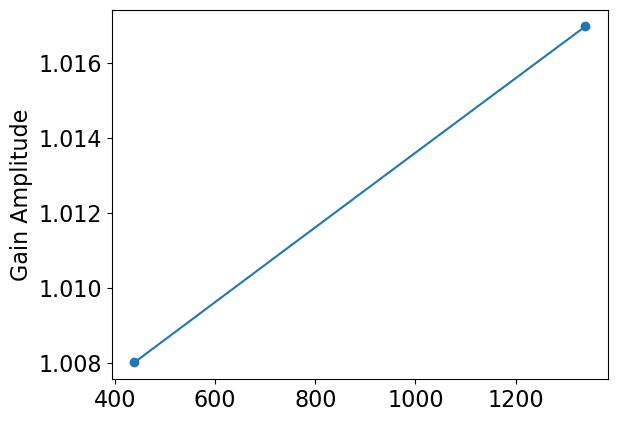

In [14]:
g_amp_var, g_amp_l = (0.01*scalings['g_amp'])**2, 1e4

g_amp_times = get_times(g_amp_l, times)

resample_g_amp = resampling_kernel(g_amp_times, times, g_amp_var, g_amp_l, noise=1e-8)

g_amp = vmap(jnp.interp, in_axes=(None,None,1), out_axes=(1))(g_amp_times, times_fine, jnp.abs(gains_ants))

plt.plot(times_fine, jnp.abs(gains_ants)[:,0])
plt.plot(g_amp_times, g_amp[:,0], 'o', color='tab:blue')
plt.ylabel('Gain Amplitude')

Text(0, 0.5, 'Gain Phase [deg]')

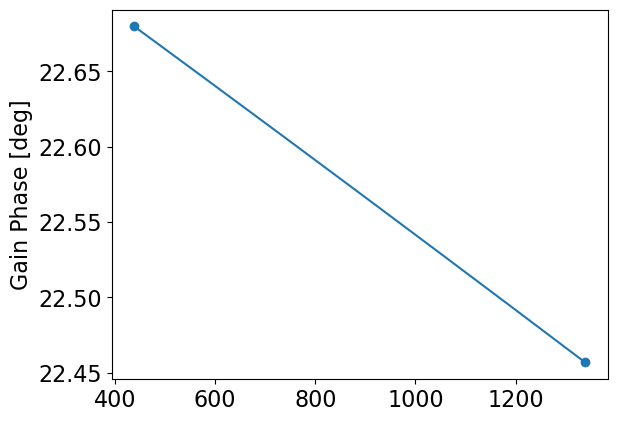

In [15]:
g_phase_var, g_phase_l = (jnp.deg2rad(1.)*scalings['g_phase'])**2, 1e4

g_phase_times = get_times(g_phase_l, times)

resample_g_phase = resampling_kernel(g_phase_times, times, g_phase_var, g_phase_l, noise=1e-8)

g_phase = vmap(jnp.interp, in_axes=(None,None,1), out_axes=(1))(g_phase_times, times_fine, jnp.angle(gains_ants))

plt.plot(times_fine, jnp.rad2deg(jnp.angle(gains_ants)[:,0]))
plt.plot(g_phase_times, jnp.rad2deg(g_phase[:,0]), 'o', color='tab:blue')
plt.ylabel('Gain Phase [deg]')

In [16]:
@jit
def rfi_closures(q, params):

    rfi_amp = jnp.stack([q['rfi_amp'][0], q['rfi_amp'][1]], axis=1)
    rfi_amp = jnp.einsum('ij,jkl->ikl', params['resample_rfi'], rfi_amp)

    rfi_xyz = vmap(orbit, in_axes=(None,0,0,0,0), out_axes=(2))(params['times_fine'], *q['rfi_orbit'])
    distances = jnp.linalg.norm(params['ants_xyz'][:,:,:,None]-rfi_xyz[:,None,:,:], axis=2)
    c_distances = (distances-params['phase_corrections'][:,:,None])

    return rfi_amp, c_distances

@jit
def rfi_vis(app_amplitude, c_distances, freqs):
    '''
    Calculate visibilities from distances to rfi sources.

    Parameters:
    -----------
    app_amplitude: jnp.array (n_time, 2, n_freq, n_src)
        Apparent amplitude at the antennas.
    c_distances: jnp.array (n_time, 2, n_src)
        The phase corrected distances between the rfi sources and the antennas.
    freqs: jnp.array (n_freq,)
        Frequencies.

    Returns:
    --------
    vis: jnp.array (n_time, 1, n_freq)
        The visibilities.
    '''
    n_time, n_ant, n_freq, n_src = app_amplitude.shape
    c = 2.99792458e8

    # Create array of shape (n_time, n_bl, n_freq, n_src) and then sum over n_src

    minus_two_pi_over_lamda = (-2.0*jnp.pi*freqs/c).reshape(1,1,n_freq,1)

    c_distances = c_distances.reshape(n_time,n_ant,1,n_src)

    phase = minus_two_pi_over_lamda*(c_distances[:,0]-c_distances[:,1])
    intensities_app = app_amplitude[:,0]*app_amplitude[:,1]

    vis = jnp.sum(intensities_app*jnp.exp(1.j*phase), axis=-1)

    return vis

@jit
def baseline_gains(q, params):
    
    G_amp = jnp.stack([q['g_amp'][0], q['g_amp'][1]], axis=0)
    G_phase = jnp.stack([q['g_phase'][0], q['g_phase'][1]], axis=0)
    
    G_amp = (params['resample_g_amp']@G_amp.T).T
    G_phase = (params['resample_g_phase']@G_phase.T).T
    

    G = G_amp*jnp.exp(1.j*G_phase)
    
    return G[0]*jnp.conjugate(G[1])

@jit
def model(q, params):
    
    q = scale_parameters(q, inv_scalings)
    
    V_ast = q['v_real'] + 1.j*q['v_imag']
    
    V_ast = params['resample_vis']@V_ast

#     Calculate the visibility contribution from the RFI
    rfi_amp, c_distances = rfi_closures(q, params)
    V_rfi = rfi_vis(rfi_amp[:,:,None,:], c_distances, params['freqs'])[...,0]
    V_rfi = V_rfi.reshape(N_time, N_int_samples).mean(axis=1)

    G_bl = baseline_gains(q, params)

    model_vis = ( G_bl * (V_ast+V_rfi) )#.reshape(N_time, N_int_samples).mean(axis=1)

    return jnp.concatenate([model_vis.real.flatten(), model_vis.imag.flatten()])

@jit
def scale_parameters(q, scalings):
    q['g_amp'] = tree_map(lambda x: scalings['g_amp']*x, q['g_amp'])
    q['g_phase'] = tree_map(lambda x: scalings['g_phase']*x, q['g_phase'])
    q['rfi_orbit'] = scalings['rfi_orbit']@q['rfi_orbit']
    return q

inv_scalings = tree_map(lambda x: jnp.linalg.inv(x) if x.ndim==2 else 1./x, scalings)

In [17]:
true_values = {'g_amp': {i: x for i, x in enumerate(g_amp.T)},
               'g_phase': {i: x for i, x in enumerate(g_phase.T)},
               'rfi_amp': {i: x for i, x in enumerate(rfi_A.T)},
               'rfi_orbit': rfi_orbit.T,
               'v_real': ast_real,
               'v_imag': ast_imag
               }

true_values = scale_parameters(true_values, scalings)

####################################################################

# Set Constant Parameters
params = {'freqs': freqs,
          'times_fine': times_fine,
          'noise': noise,
          'ants_xyz': ants_xyz,
          'phase_corrections': ants_uvw[...,-1],
          'vis_obs': vis_obs,
          }

def sym(x):
    return (x + x.T)/2.

cov_RFI_orbit = scalings['rfi_orbit']@np.load('/Users/chrisfinlay/Documents/PhD/tabascal/tabascal/RFIcov5min.npy')@scalings['rfi_orbit']
inv_cov_RFI_orbit = sym(jnp.linalg.inv(cov_RFI_orbit))
inv_cov_RFI_orbit = jnp.stack([inv_cov_RFI_orbit for _ in range(len(rfi_A))], axis=2)

prior_params = {'mu_RFI_orbit': scalings['rfi_orbit']@rfi_orbit.T,
                'inv_cov_RFI_orbit': inv_cov_RFI_orbit,
                'mu_G_amp': scalings['g_amp']*g_amp,
                'mu_G_phase': scalings['g_phase']*g_phase,
                'rfi_amp_std': 100.0,
                # 'mu_vis_real': jnp.zeros(len(ast_times)),
                # 'mu_vis_imag': jnp.zeros(len(ast_times)),
                'mu_vis_real': ast_real.mean()*jnp.ones(len(ast_times)),
                'mu_vis_imag': ast_imag.mean()*jnp.ones(len(ast_times)),
                'inv_cov_vis': inv_kernel(ast_times[:,None], ast_var, ast_l),
                'inv_cov_G_amp': inv_kernel(g_amp_times[:,None], g_amp_var, g_amp_l),
                'inv_cov_G_phase': inv_kernel(g_phase_times[:,None], g_phase_var, g_phase_l),
                'resample_vis': resample_ast,
                'resample_g_amp': resample_g_amp,
                'resample_g_phase': resample_g_phase,
                'resample_rfi': resample_rfi
               }

params.update(prior_params)

In [18]:
@jit
def nlp(q, params):
    
    rfi_amp = jnp.stack([q['rfi_amp'][0], q['rfi_amp'][1]], axis=1)
    G_amp = jnp.stack([q['g_amp'][0], q['g_amp'][1]], axis=0)
    G_phase = jnp.stack([q['g_phase'][0], q['g_phase'][1]], axis=0)
    
    log_multinorm_map = vmap(log_multinorm, in_axes=(0,1,None))
    
    lp = jnp.sum(log_multinorm_map(G_amp, params['mu_G_amp'], params['inv_cov_G_amp'])) + \
         jnp.sum(log_multinorm_map(G_phase, params['mu_G_phase'], params['inv_cov_G_phase']))
    
    lp += jnp.sum(vmap(log_multinorm, in_axes=(0,1,2))(q['rfi_orbit'].T, params['mu_RFI_orbit'], params['inv_cov_RFI_orbit'])) + \
          jnp.sum(log_normal(rfi_amp, 0.0, params['rfi_amp_std']))
    
    lp += log_multinorm(q['v_real'], params['mu_vis_real'], params['inv_cov_vis']) + \
          log_multinorm(q['v_imag'], params['mu_vis_imag'], params['inv_cov_vis'])

    return -1.0*lp

@jit
def nll(q, params):

    V_model = model(q, params)

    V_obs = jnp.concatenate([params['vis_obs'].real,
                             params['vis_obs'].imag])

    return -1. * log_normal(V_obs, V_model, params['noise'])

@jit
def U(q, params):

    nl_like = nll(q, params).sum()
        
    nl_post = nlp(q, params) + nl_like

    return nl_post

delU = jit(jacrev(U, 0))

In [19]:
%timeit -r 3 nlp.lower(true_values, params).compile()

63.7 ms ± 1.02 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [20]:
%timeit -r 3 nll.lower(true_values, params).compile()

123 ms ± 1.53 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [21]:
n_log = nll(true_values, params)
n_log = n_log.T[N_time:] + n_log.T[:N_time]
n_log.mean()

Array(1.13165968, dtype=float64)

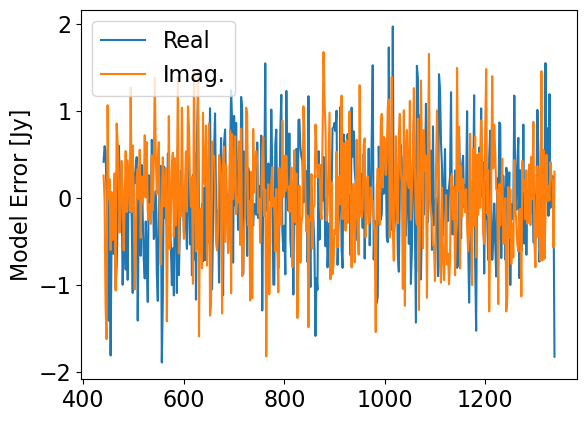

In [22]:
vis_m = model(true_values, params)
plt.plot(times, vis_obs.real - vis_m[:N_time], label='Real')
plt.plot(times, vis_obs.imag - vis_m[N_time:], label='Imag.')
plt.ylabel('Model Error [Jy]')
plt.legend()
# plt.xlim(200, 450)

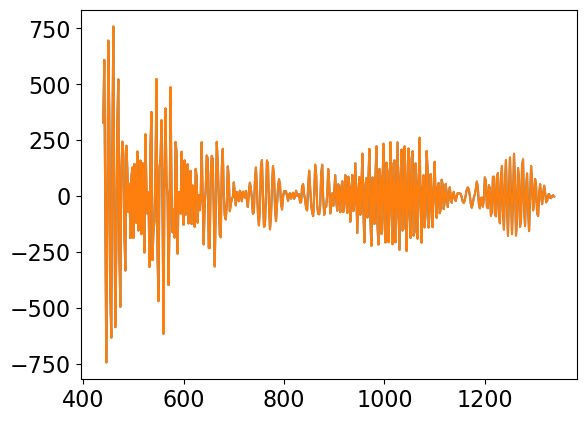

In [23]:
vis_m = model(true_values, params)
plt.plot(times, vis_obs.real, label='Real')
plt.plot(times, vis_m[:N_time])
# plt.xlim(0, 50)

In [24]:
%timeit -r 3 U.lower(true_values, params).compile()

184 ms ± 598 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [25]:
print()
print(f'Energy per data point @ true: {U(true_values, params)/vis_obs.size}')
print()
print(f'U compiled {U._cache_size()} time(s).')


Energy per data point @ true: 1.1776982019845497

U compiled 1 time(s).


In [26]:
q_dev = {'v_real': noise*random.normal(random.PRNGKey(10), (len(ast_times),)),
         'v_imag': noise*random.normal(random.PRNGKey(11), (len(ast_times),)),
         'g_amp':  {i: x for i, x in enumerate(1.0*random.normal(random.PRNGKey(12), (N_ant,)))},
         'g_phase': {i: x for i, x in enumerate(1.0*random.normal(random.PRNGKey(13), (N_ant,)))},
         'rfi_amp': {i: x for i, x in enumerate(10.*random.normal(random.PRNGKey(14), (N_ant,)))},
         'rfi_orbit': random.multivariate_normal(random.PRNGKey(15),
                                                 jnp.zeros(len(cov_RFI_orbit)),
                                                 1e0*cov_RFI_orbit, shape=(true_values['rfi_orbit'].shape[1],)).T
        }

qi = tree_map(lambda x, y: x + y, true_values, q_dev)

# qi = {
#     'v_real': jnp.zeros(len(ast_times)),
#     'v_imag': jnp.zeros(len(ast_times)),
#     'g_amp':  {i: x for i, x in qi['g_amp'].items()},
#     'g_phase': {i: x for i, x in qi['g_phase'].items()},
#     'rfi_amp': {i: jnp.interp(rfi_times, times, jnp.sqrt(jnp.abs(vis_obs)/2))[:,None]*jnp.ones((1,len(rfi_A))) for i in range(N_ant)},
#     'rfi_orbit': random.multivariate_normal(random.PRNGKey(15),
#                                                  jnp.zeros(len(cov_RFI_orbit)),
#                                                  1e0*cov_RFI_orbit, shape=(true_values['rfi_orbit'].shape[1],)).T
# }

#########################################

print()
print(f'Number of data points: {2*vis_obs.size}')
print()
print(f'Number of parameters: {len(flatten(qi)[0])}')
print()
print(f'Energy per data point @ qi: {U(qi, params)/vis_obs.size}')
print()
# print(f'U compiled {U._cache_size()} time(s).')
# print()


Number of data points: 900

Number of parameters: 270

Energy per data point @ qi: 9863.717233303316



In [27]:
###### Tensordot implementation ########

# rfi_amp_inv_cov = 1./params['rfi_amp_std']**2
# axes = true_values['rfi_amp'].shape
# extra_dims = ((0,1,4,5), (0,2,3,5), (1,2,3,4))
# for ax, dims in zip(axes, extra_dims):
#     rfi_amp_inv_cov *= jnp.expand_dims(jnp.eye(ax), dims)
    
# rfi_orbit_inv_cov = jnp.expand_dims(jnp.ones_like(params['inv_cov_RFI_orbit']), axis=0).T * jnp.expand_dims(params['inv_cov_RFI_orbit'], axis=0)

# F_prior_block1 = {
#     'g_amp': {i: params['inv_cov_G_amp'] for i in range(N_ant)},
#     'g_phase': {i: params['inv_cov_G_phase'] for i in range(N_ant)},
#     'rfi_amp': rfi_amp_inv_cov,
#     'rfi_orbit': rfi_orbit_inv_cov,
#     'v_real': params['inv_cov_vis'],
#     'v_imag': params['inv_cov_vis'],
# }

# def fisher_block1(q, params, F_prior_block):
    
#     J = jacrev(model)(q, params)
#     F_block = tree_map(lambda J, prior: jnp.tensordot(J.T, J, 1)/params['noise']**2 + prior, J, F_prior_block)
    
#     return F_block

# def tensorinv(x):
#     ndim = x.ndim
#     if ndim<2:
#         return 1./x
#     new_dims = list(jnp.arange(ndim//2-1, -1, -1))+list(ndim-1-jnp.arange(ndim//2))
#     y = jnp.linalg.tensorinv(x, ndim//2)
#     y = jnp.moveaxis(y, jnp.arange(ndim), new_dims)
#     return y

# F = fisher_block(qi, params, F_prior_block)
# F_inv = tree_map(tensorinv, F)

# # @jit
# def nat_grad_step(q, alpha):
#     update = lambda F_inv, D: alpha*jnp.tensordot(F_inv, D, D.ndim).T
#     D = delU(q, params)
#     return tree_map(update, F_inv, D)

In [28]:
def fisher_diag(q, params, F_prior_diag):
    Jac = jacrev(model)(q, params)
    F = lambda J, prior: jnp.sum(J**2, axis=0)/params['noise']**2 + prior
    F_diag = tree_map(F, Jac, F_prior_diag)
    
    return F_diag

def diag_std(x):
    return tree_map(lambda x: 1./jnp.sqrt(x), x)

F_prior_diag = {
    'g_amp': {i: 1./jnp.diag(jnp.linalg.inv(params['inv_cov_G_amp'])) for i in range(N_ant)},
    'g_phase': {i: 1./jnp.diag(jnp.linalg.inv(params['inv_cov_G_phase'])) for i in range(N_ant)},
    'rfi_amp': {i: jnp.ones((true_values['rfi_amp'][0].shape))//params['rfi_amp_std']**2 for i in range(N_ant)},
    'rfi_orbit': 1./vmap(jnp.diag, in_axes=(2), out_axes=(1))(params['inv_cov_RFI_orbit']),
    'v_real': 1./jnp.diag(jnp.linalg.inv(params['inv_cov_vis'])),
    'v_imag': 1./jnp.diag(jnp.linalg.inv(params['inv_cov_vis'])),
}

F = fisher_diag(qi, params, F_prior_diag)
F_inv = tree_map(lambda x: 1./x, F)

@jit
def nat_grad_step(q, alpha):
    update = lambda F_inv, D: alpha*F_inv*D
    D = delU(q, params)
    return tree_map(update, F_inv, D)

In [29]:
# flat_true, unflatten = flatten(true_values)
# @jit
# def flat_nll(flat_q, params):
#     q = unflatten(flat_q)
#     return nll(q, params)
# @jit
# def flat_nlp(flat_q, params):
#     q = unflatten(flat_q)
#     return nlp(q, params)

# J = jacrev(flat_nll)(flat_true, params)
# H = hessian(flat_nlp)(flat_true, params)
# F = -J.T@J + H 

# @jit
# def flat_U(flat_q, params):
#     q = unflatten(flat_q)
#     return U(q, params)

# flat_delU = jit(jacrev(flat_U))

In [30]:
# from jax import hessian

# H = hessian(nlp)(true_values, params)

# F_prior_H = {
#     'g_amp': {i: H['g_amp'][i]['g_amp'][i] for i in H['g_amp'].keys()},
#     'g_phase': {i: H['g_phase'][i]['g_phase'][i] for i in H['g_phase'].keys()},
#     'rfi_amp': {i: H['rfi_amp'][i]['rfi_amp'][i] for i in H['rfi_amp'].keys()},
# }

In [31]:
# def fisher(q, params, F_prior):
#     J = flatten(jacrev(model)(q, params))[0]
#     F = J.T@J/params['noise']**2 #+ block_diag(F_prior['ast_imag'], F_prior['ast_real'], 
#                                   #            F_prior['rfi_imag'], F_prior['rfi_real'])
    
#     return F

################
# def block_std(F_block):

#     std = tree_map(lambda F: jnp.sqrt(jnp.diag(jnp.linalg.inv(F))), F_block)

#     return std

In [32]:
# ###### Einsum implementation ########### 

# @jit
# def xTx(x):
#     x_ = x.reshape(x.shape[0], x.shape[1], -1)
#     xx = jnp.einsum('ijk,ilk->jlk', x_, x_).reshape(x.shape[1], *x.shape[1:])
#     return xx

# def fisher_block(q, params, F_prior_block):
    
#     Jac = jacrev(model)(q, params)
#     F_block = tree_map(lambda J, prior: xTx(J) + prior, Jac, F_prior_block)
    
#     return F_block

# def inv(A):
#     A_ = A.reshape(A.shape[0], A.shape[1], -1)
#     A_inv = vmap(jnp.linalg.inv, in_axes=(-1), out_axes=(-1))(A_)
#     return A_inv.reshape(A.shape)

# def block_std(F_inv):
#     F_inv_ = F_inv.reshape(F_inv.shape[0], F_inv.shape[1], -1)
#     std = vmap(lambda x: jnp.sqrt(jnp.diag(x)), in_axes=(-1), out_axes=(-1))(F_inv_)
#     return std.reshape(F_inv.shape[1:])

# n_rfi, n_rfi_t = rfi_A.shape[:2]

# F_prior_block = {
#     'g_amp': {i: params['inv_cov_G_amp'] for i in range(N_ant)},
#     'g_phase': {i: params['inv_cov_G_phase'] for i in range(N_ant)},
#     'rfi_amp': {i: jnp.eye(len(rfi_times))[:,:,None]*jnp.ones((n_rfi_t,n_rfi_t,n_rfi))//params['rfi_amp_std']**2 for i in range(N_ant)},
#     'rfi_orbit': params['inv_cov_RFI_orbit'],
#     'v_real': params['inv_cov_vis'],
#     'v_imag': params['inv_cov_vis'],
# }

# F = fisher_block(qi, params, F_prior_block)
# F_inv = tree_map(inv, F)

# # @jit
# def nat_grad_step(q, alpha):
#     update = lambda A, x: jnp.einsum('ij...,j...->i...', A, x)
#     D = delU(q, params)
#     return tree_map(update, F_inv, D)

In [ ]:
def nat_grad(qi, alpha, Niter=1000, tol=1e-6):
    U_i = U(qi, params)/vis_obs.size
    pbar = tqdm(range(0, Niter, 100))
    for i in pbar:
        # step = alpha*0.99**(i/1000)
        step = alpha
        
        def update(qi, i):
            return tree_map(lambda x, y: x-y, qi, nat_grad_step(qi, step)), i
        qf = scan(update, qi, jnp.arange(100))[0]
        
        U_f = U(qf, params)/vis_obs.size
        pbar.set_description(f'NL Posterior = {round(float(U_f), 3)}, alpha = {step:.1E}')
        if U_i-U_f < tol :
            return qi
        if jnp.isnan(U_f) or U_f > U_i:
            alpha /= 2.
            continue
        U_i = U_f
        qi = qf
    return qi

# MAP = nat_grad(qi, 5e-1, 10000, 1e-5)
MAP = nat_grad(MAP, 2e-2, 10000, 1e-5)
# MAP = nat_grad(true_values, 5e-4, 10000, 1e-5)
# MAP = true_values

print()
print(f'U compiled {U._cache_size()} time(s).')
print()
# print(f'nat_grad_step compiled {nat_grad_step._cache_size()} time(s).')

NL Posterior = 3.49, alpha = 2.0E-02:   2%|███                                                                                                                                                         | 2/100 [00:03<02:40,  1.64s/it]

In [169]:
# std = block_std(fisher_block(MAP, params, F_prior_block))

In [34]:
std = diag_std(fisher_diag(MAP, params, F_prior_diag))

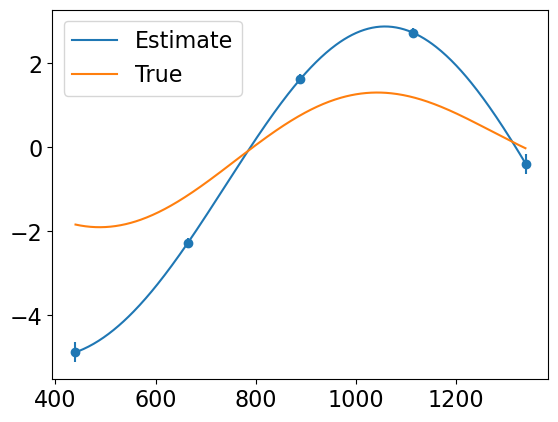

In [35]:
plt.plot(times, resample_ast@MAP['v_real'], color='tab:blue', label='Estimate')
plt.errorbar(ast_times, MAP['v_real'], std['v_real'], fmt='o', color='tab:blue')
plt.plot(times, (vis_ast.reshape(N_time,-1).mean(axis=1)).real, color='tab:orange', label='True')
plt.legend()

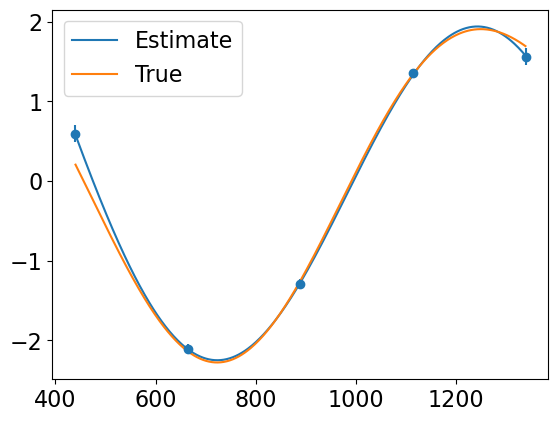

In [43]:
plt.plot(times, resample_ast@MAP['v_imag'], color='tab:blue', label='Estimate')
plt.errorbar(ast_times, MAP['v_imag'], std['v_imag'], fmt='o', color='tab:blue')
plt.plot(times, (vis_ast.reshape(N_time,-1).mean(axis=1)).imag, color='tab:orange', label='True')
plt.legend()

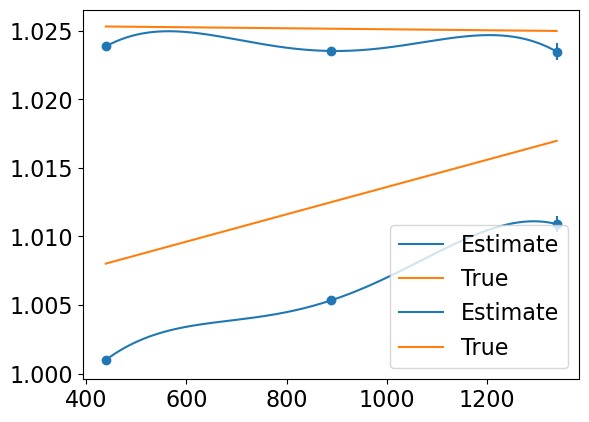

In [44]:
for i in range(N_ant):
    plt.plot(times, resample_g_amp@MAP['g_amp'][i]/100, color='tab:blue', label='Estimate')
    plt.errorbar(g_amp_times, MAP['g_amp'][i]/100, std['g_amp'][i]/100, fmt='o', color='tab:blue')
    plt.plot(times_fine, jnp.abs(gains_ants[:,i]), color='tab:orange', label='True')
plt.legend()

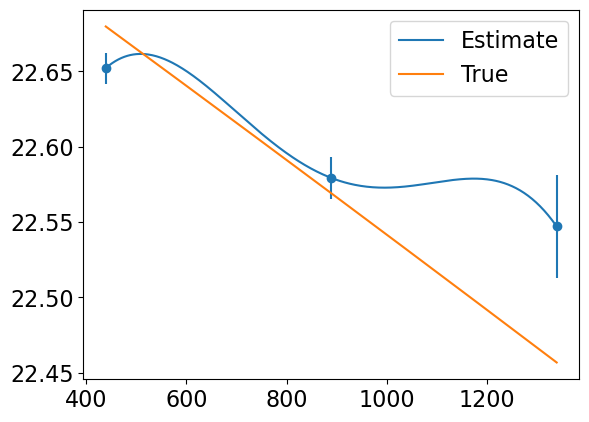

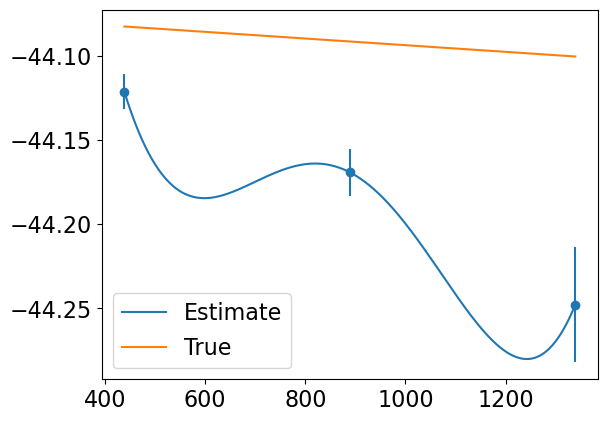

In [45]:
for i in range(N_ant):
    plt.figure()
    plt.plot(times, resample_g_amp@MAP['g_phase'][i], color='tab:blue', label='Estimate')
    plt.errorbar(g_amp_times, MAP['g_phase'][i], std['g_phase'][i], fmt='o', color='tab:blue')
    plt.plot(times_fine, jnp.rad2deg(jnp.angle(gains_ants[:,i])), color='tab:orange', label='True')
    plt.legend()

In [7]:
v_ast = vis_ast.reshape(-1, N_int_samples).mean(axis=1)

In [8]:
samplings = (2**jnp.arange(3, 9).astype(float)).astype(int)
errs = jnp.zeros(len(samplings))
for j, i in enumerate(samplings):
    ast_avg = vis_ast.reshape(-1, i).mean(axis=1)
    ast_times = times_fine[i//2::i]
    v_ast_avg = resampling_kernel(ast_times, times, ast_var, ast_l)@ast_avg
    errs = errs.at[j].set(jnp.sqrt(jnp.mean(jnp.abs(v_ast_avg-v_ast)**2)))

NameError: name 'resampling_kernel' is not defined

In [ ]:
samplings

In [ ]:
plt.plot(samplings, errs)

In [ ]:
v_ast_avg.shape

In [ ]:
ast_var = (jnp.abs(vis_ast).max(axis=(0)) + noise)**2
mag_uvw = jnp.linalg.norm(bl_uvw[0], axis=-1)
l = l_from_uv(mag_uvw, l0=5e2)

In [90]:
ast_times = get_times(l, times)
resample_ast = resampling_kernel(ast_times, times, ast_var, ast_l)

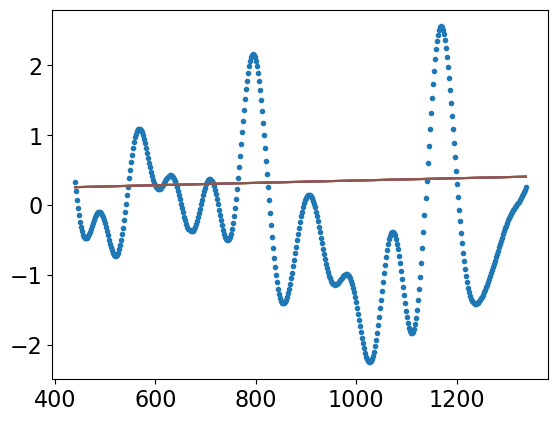

In [44]:
plt.plot(times, v_ast.real, '.')
ls = jnp.arange(10, 60, 10.)
errs = jnp.zeros(len(ls))
for j, l in enumerate(ls):
    ast_times = get_times(l, times)
    resample_ast = resampling_kernel(ast_times, times, ast_var, l)
    v = jnp.interp(ast_times, times_fine, vis_ast)
    v_ast_avg = resample_ast@v
    errs = errs.at[j].set(jnp.sqrt(jnp.mean(jnp.abs(v_ast_avg-v_ast)**2)))
    plt.plot(times, v_ast_avg.real)
    # plt.plot(ast_times, v, 'o')

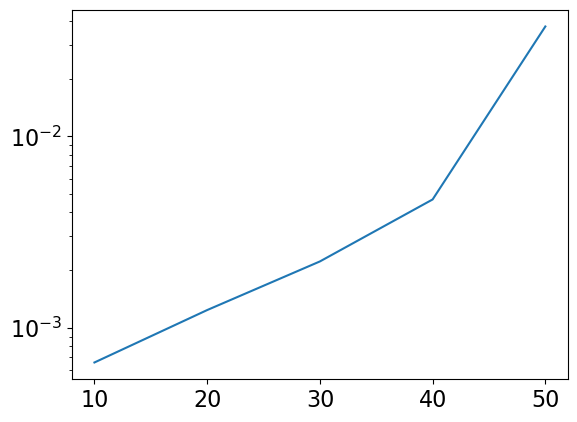

In [101]:
plt.semilogy(ls, errs)

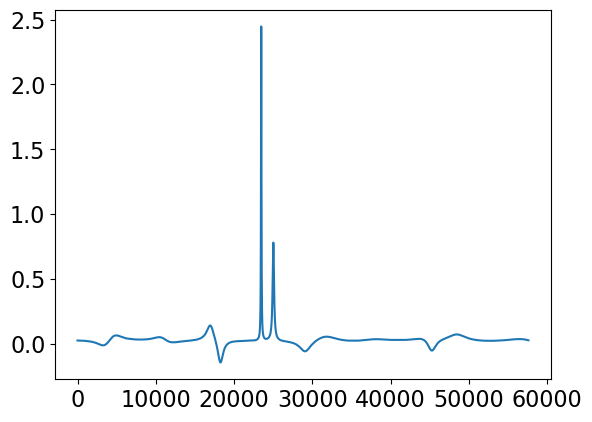

In [108]:
plt.plot(8*jnp.diff(jnp.unwrap(jnp.angle(vis_rfi))/(2*jnp.pi))/jnp.diff(times_fine))

In [109]:
rfi_phase_times = get_times(jnp.abs(8*jnp.diff(jnp.unwrap(jnp.angle(vis_rfi))/(2*jnp.pi))/jnp.diff(times_fine)).max(), times)

In [110]:
rfi_phase_times.size

737

In [ ]:
len(times

In [112]:
from tabascal.utils.tools import get_factors

In [116]:
N_int_samples*get_factors(len(times))

Array([  128,   256,   384,   640,   768,  1152,  1280,  1920,  2304,
        3200,  3840,  5760,  6400,  9600, 11520, 19200, 28800, 57600],      dtype=int64)

In [ ]:
# bl = 37

# norm = jnp.sqrt(jnp.outer(jnp.diag(F_inv['v_real'][bl]), jnp.diag(F_inv['v_real'][bl])))
# norm = jnp.ones(F_inv['v_real'][bl].shape)
# plt.imshow(F_inv['v_real'][bl]/norm)
# plt.colorbar()

# plt.figure()
# norm = jnp.sqrt(jnp.outer(jnp.diag(F_prior_inv['v_real'][bl]), jnp.diag(F_prior_inv['v_real'][bl])))
# norm = jnp.ones(F_inv['v_real'][bl].shape)
# plt.imshow(F_prior_inv['v_real'][bl]/norm)
# plt.colorbar()

In [ ]:
# F_prior_inv = tree_map(jnp.linalg.inv, F_prior)

In [173]:
def saveParams(file_path, q, F_inv):
    with h5py.File(file_path, 'w') as fp:
        fp['times_fine'] = times
        
        for i in range(len(q['v_real'])):
            fp[f'vis/{i}'] = q['v_real'][i] + 1.j*q['v_imag'][i]
            fp[f'vis_cov/{i}'] = F_inv['v_real'][i]
            fp[f'vis_times/{i}'] = vis_times[i]
        fp['vis_var'] = vis_var
        fp['vis_l'] = vis_l
        
        V_real = flatten(tree_map(pad_vis, q['v_real']))[0].reshape(N_bl, N_vis_time)
        V_imag = flatten(tree_map(pad_vis, q['v_imag']))[0].reshape(N_bl, N_vis_time)
        fp['vis_fine'] = vmap(jnp.dot)(params['resample_vis'], (V_real + 1.j*V_imag))
        
        G_amp = flatten(q['g_amp'])[0].reshape(N_ant, N_g_time)
        G_phase = flatten(q['g_phase'])[0].reshape(N_ant-1, N_g_time)
        G_phase = jnp.concatenate([G_phase, jnp.zeros((1, N_g_time))], axis=0)
        G = G_amp*jnp.exp(1.j*G_phase)
        fp['gains'] = G

        G_amp = (params['resample_g_amp']@G_amp.T)
        G_phase = (params['resample_g_phase']@G_phase.T)
        G = G_amp*jnp.exp(1.j*G_phase)
        fp['gains_fine'] = G
        
        rfi_amp = flatten(q['rfi_amp'])[0].reshape(N_ant, N_rfi_time).T
        fp['rfi_amp'] = rfi_amp
        fp['rfi_amp_fine'] = params['resample_rfi']@rfi_amp
        fp['rfi_orbit'] = q['rfi_orbit']
        
        fp['g_amp_cov'] = flatten(F_inv['g_amp'])[0].reshape(N_ant,N_g_time,N_g_time)
        
        fp['g_phase_cov'] = flatten(F_inv['g_phase'])[0].reshape(N_ant-1,N_g_time,N_g_time)
        
        fp['rfi_amp_cov'] = flatten(F_inv['rfi_amp'])[0].reshape(N_ant,N_rfi_time,N_rfi_time)
        fp['rfi_orbit_cov'] = F_inv['rfi_orbit']

In [40]:
saveParams(f'Params_{N_ant}A_Reduced.h5', MAP, F_inv)

In [ ]:
# saveParams(f'Params_{N_ant}A_Reduced.h5', true_values, F_inv)

In [42]:
print()
print('Estimating Posterior Errors')
print('---------------------------')

std = block_std(F)

with h5py.File(f'Params_{N_ant}A_Reduced.h5', 'r') as fp:
    v_pred = fp['vis_fine'][()].T
    noise_cov = {i: fp['vis_cov'][f'{i}'][()] for i in range(N_bl)}
    vis_times = {i: fp['vis_times'][f'{i}'][()] for i in range(N_bl)}
    vis_var_d = {i: fp['vis_var'][i] for i in range(N_bl)}
    vis_l_d = {i: fp['vis_l'][i] for i in range(N_bl)}
v_pred = jnp.concatenate([v_pred.real.flatten(), v_pred.imag.flatten()])
cov_fine = tree_map(resampled_cov, vis_times, {i: times for i in range(N_bl)}, vis_var_d, vis_l_d, noise_cov)
v_std = vmap(lambda x: jnp.sqrt(jnp.diag(x)))(flatten(cov_fine)[0].reshape(N_bl,N_time,N_time))
v_std = jnp.sqrt(jnp.concatenate([v_std.flatten(), v_std.flatten()]))
v_true = vis_ast.reshape(N_time, N_int_samples, -1).mean(axis=1)
v_true = jnp.concatenate([v_true.real.flatten(), v_true.imag.flatten()])
res = v_pred - v_true

bias = res/v_std

print()
print(f'RMSE : {jnp.sqrt(jnp.mean(res**2))}')
print()
print(f'STD : {v_std.mean()}')
print()
print('Normalized')
print('-----------')
print(f'Mean : {bias.mean()}')
print(f'STD : {bias.std()}')


Estimating Posterior Errors
---------------------------

RMSE : 0.028038502248016815

STD : 0.24898896597952028

Normalized
-----------
Mean : -0.027075395103504193
STD : 0.10836506523842043


In [43]:
b = jnp.abs(bias)
100*len(b[b<1])/len(b)

100.0

In [44]:
print()
print(f'End Time : {datetime.now()}')
print()
print(f'Time Taken: {datetime.now()-start}')


End Time : 2023-03-20 14:50:55.264697

Time Taken: 0:02:07.748383


Text(0, 0.5, 'Visibility Real [Jy]')

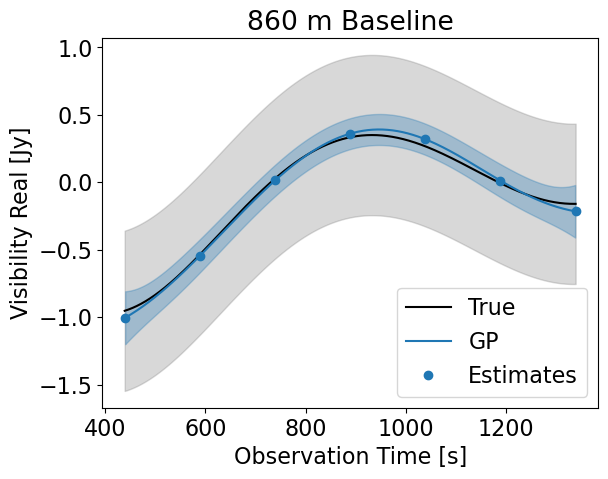

In [46]:
bl = int(jnp.argmin(flatten(vis_l)[0]))
n_std = 2

with h5py.File(f'Params_{N_ant}A_Reduced.h5', 'r') as fp:
    vis = {i: fp[f'vis'][f'{i}'][()] for i in range(N_bl)}
    v_pred = fp['vis_fine'][()].T
    noise_cov = {i: fp['vis_cov'][f'{i}'][()] for i in range(N_bl)}
cov_fine = tree_map(resampled_cov, vis_times, {i: times for i in range(N_bl)}, vis_var_d, vis_l_d, noise_cov)
v_std = vmap(lambda x: jnp.sqrt(jnp.diag(x)))(flatten(cov_fine)[0].reshape(N_bl,N_time,N_time)).T

est = vis[bl].real
mean = v_pred[:,bl].real
std = v_std[:,bl]
true = vis_ast[:,bl,0].real
noise = noise/jnp.sqrt(2.)

plt.plot(times_fine, true, color='k', label='True')
plt.fill_between(times_fine, true-n_std*noise, true+n_std*noise, 
                 color='tab:grey', alpha=0.3, 
#                  label=f'{int(n_std)}'+r'$\sigma$'
                )
plt.plot(times, mean, color='tab:blue', label='GP')
plt.fill_between(times, mean-n_std*std, mean+n_std*std, 
                 color='tab:blue', alpha=0.3, 
#                  label=f'{int(n_std)}'+r'$\sigma$'
                )
plt.plot(vis_times[bl], est, 'o', color='tab:blue', label='Estimates')

plt.legend()
plt.title(f'{round(mag_uvw[bl])} m Baseline')
plt.xlabel('Observation Time [s]')
plt.ylabel('Visibility Real [Jy]')

Text(0, 0.5, 'Visibility Real [Jy]')

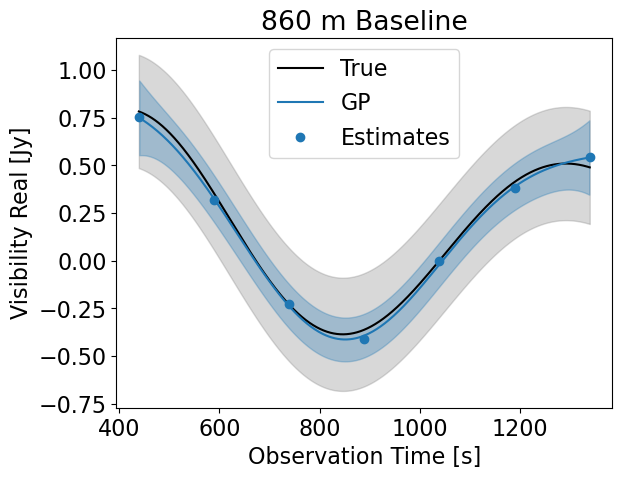

In [49]:
bl = int(jnp.argmin(flatten(vis_l)[0]))
n_std = 2

with h5py.File(f'Params_{N_ant}A_Reduced.h5', 'r') as fp:
    vis = {i: fp[f'vis'][f'{i}'][()] for i in range(N_bl)}
    v_pred = fp['vis_fine'][()].T
    noise_cov = {i: fp['vis_cov'][f'{i}'][()] for i in range(N_bl)}
cov_fine = tree_map(resampled_cov, vis_times, {i: times for i in range(N_bl)}, vis_var_d, vis_l_d, noise_cov)
v_std = vmap(lambda x: jnp.sqrt(jnp.diag(x)))(flatten(cov_fine)[0].reshape(N_bl,N_time,N_time)).T

est = vis[bl].imag
mean = v_pred[:,bl].imag
std = v_std[:,bl]
true = vis_ast[:,bl,0].imag
noise = noise/jnp.sqrt(2.)

plt.plot(times_fine, true, color='k', label='True')
plt.fill_between(times_fine, true-n_std*noise, true+n_std*noise, 
                 color='tab:grey', alpha=0.3, 
#                  label=f'{int(n_std)}'+r'$\sigma$'
                )
plt.plot(times, mean, color='tab:blue', label='GP')
plt.fill_between(times, mean-n_std*std, mean+n_std*std, 
                 color='tab:blue', alpha=0.3, 
#                  label=f'{int(n_std)}'+r'$\sigma$'
                )
plt.plot(vis_times[bl], est, 'o', color='tab:blue', label='Estimates')

plt.legend()
plt.title(f'{round(mag_uvw[bl])} m Baseline')
plt.xlabel('Observation Time [s]')
plt.ylabel('Visibility Real [Jy]')

Text(0, 0.5, 'Visibility Real [Jy]')

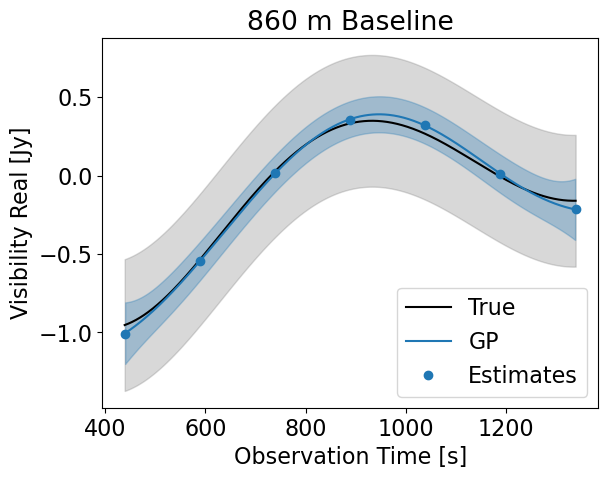

In [48]:
bl = int(jnp.argmin((mag_uvw-3000)**2))
n_std = 2

with h5py.File(f'Params_{N_ant}A_Reduced.h5', 'r') as fp:
    vis = {i: fp[f'vis'][f'{i}'][()] for i in range(N_bl)}
    v_pred = fp['vis_fine'][()].T
    noise_cov = {i: fp['vis_cov'][f'{i}'][()] for i in range(N_bl)}
cov_fine = tree_map(resampled_cov, vis_times, {i: times for i in range(N_bl)}, vis_var_d, vis_l_d, noise_cov)
v_std = vmap(lambda x: jnp.sqrt(jnp.diag(x)))(flatten(cov_fine)[0].reshape(N_bl,N_time,N_time)).T

est = vis[bl].real
mean = v_pred[:,bl].real
std = v_std[:,bl]
true = vis_ast[:,bl,0].real
noise = noise/jnp.sqrt(2.)

plt.plot(times_fine, true, color='k', label='True')
plt.fill_between(times_fine, true-n_std*noise, true+n_std*noise, 
                 color='tab:grey', alpha=0.3, 
#                  label=f'{int(n_std)}'+r'$\sigma$'
                )
plt.plot(times, mean, color='tab:blue', label='GP')
plt.fill_between(times, mean-n_std*std, mean+n_std*std, 
                 color='tab:blue', alpha=0.3, 
#                  label=f'{int(n_std)}'+r'$\sigma$'
                )
plt.plot(vis_times[bl], est, 'o', color='tab:blue', label='Estimates')

plt.legend()
plt.title(f'{round(mag_uvw[bl])} m Baseline')
plt.xlabel('Observation Time [s]')
plt.ylabel('Visibility Real [Jy]')

Text(0, 0.5, 'Visibility Real [Jy]')

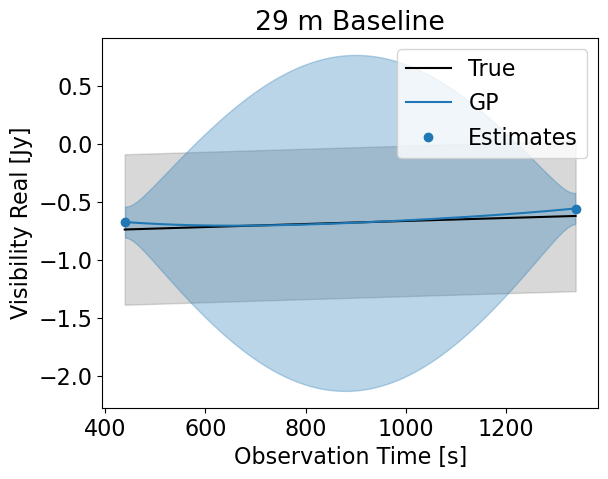

In [36]:
bl = int(jnp.argmax(flatten(vis_l)[0]))
n_std = 2

with h5py.File(f'Params_{N_ant}A_Reduced.h5', 'r') as fp:
    vis = {i: fp[f'vis'][f'{i}'][()] for i in range(N_bl)}
    v_pred = fp['vis_fine'][()].T
    noise_cov = {i: fp['vis_cov'][f'{i}'][()] for i in range(N_bl)}
cov_fine = tree_multimap(resampled_cov, vis_times, {i: times for i in range(N_bl)}, vis_var_d, vis_l_d, noise_cov)
v_std = vmap(lambda x: jnp.sqrt(jnp.diag(x)))(flatten(cov_fine)[0].reshape(N_bl,N_time,N_time)).T

est = vis[bl].real
mean = v_pred[:,bl].real
std = v_std[:,bl]
true = vis_ast[:,bl,0].real
noise = noise/jnp.sqrt(2.)

plt.plot(times_fine, true, color='k', label='True')
plt.fill_between(times_fine, true-n_std*noise, true+n_std*noise, 
                 color='tab:grey', alpha=0.3, 
#                  label=f'{int(n_std)}'+r'$\sigma$'
                )
plt.plot(times, mean, color='tab:blue', label='GP')
plt.fill_between(times, mean-n_std*std, mean+n_std*std, 
                 color='tab:blue', alpha=0.3, 
#                  label=f'{int(n_std)}'+r'$\sigma$'
                )
plt.plot(vis_times[bl], est, 'o', color='tab:blue', label='Estimates')

plt.legend()
plt.title(f'{round(mag_uvw[bl])} m Baseline')
plt.xlabel('Observation Time [s]')
plt.ylabel('Visibility Real [Jy]')

In [18]:
@jit
def vis_prior(q):
    V_real = flatten(tree_map(pad_vis, q['v_real']))[0].reshape(N_bl, N_vis_time)
#     V_imag = flatten(tree_map(pad_vis, q['v_imag']))[0].reshape(N_bl, N_vis_time)
    return log_multinorm_sum(V_real, jnp.zeros(N_bl), inv_cov_vis)

In [19]:
@jit
def vis_prior2(q):
    V_real = flatten(q['v_real'])[0]
#     V_imag = flatten(tree_map(pad_vis, q['v_imag']))[0].reshape(N_bl, N_vis_time)
    return log_normal(V_real, jnp.zeros(len(V_real)), sigma).sum()

In [20]:
%timeit -r 7 vis_prior.lower(true_values).compile()

7.41 s ± 342 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%timeit -r 7 vis_prior2.lower(true_values).compile()

417 ms ± 943 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
vis_prior(true_values)

Array(-139.85498607, dtype=float64)

In [23]:
vis_prior2(true_values)

Array(-178.49932835, dtype=float64)

In [24]:
log_multinorm_sum_dict(true_values['v_real'], params['mu_vis'], params['inv_cov_vis'])

NameError: name 'log_multinorm_sum_dict' is not defined

In [13]:
@jit
def log_multinorm_dict(x, mu, inv_cov):
    return tree_multimap(log_multinorm, x, mu, inv_cov)

In [14]:
%timeit -r 7 log_multinorm_dict.lower(true_values['v_real'], params['mu_vis'], params['inv_cov_vis']).compile()

9.46 s ± 597 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%timeit -r 7 log_multinorm_sum_dict.lower(true_values['v_real'], params['mu_vis'], params['inv_cov_vis']).compile()

NameError: name 'log_multinorm_sum_dict' is not defined

In [ ]:
%timeit -r 7 log_multinorm_sum_array.lower(flatten(true_values['g_amp'])[0].reshape(N_ant, N_g_time), params['mu_G_amp'], params['inv_cov_G_amp']).compile()

In [4]:
# class tabascal:
#     def __init__(self, n_ant: int, times: jnp.ndarray, times_fine: jnp.ndarray, freqs: jnp.ndarray, 
#                  qi: dict, true_values: dict, n_int_samples: int, n_rfi_time: int, n_g_time: int, 
#                  n_vis_time: int, scalings: dict, inv_scalings: dict, n_bl: int, noise: float, 
#                  vis_obs: jnp.ndarray, ants_xyz: jnp.ndarray, phase_corrections: jnp.ndarray, 
#                  resamplings: dict, antenna1: jnp.ndarray, antenna2: jnp.ndarray
#                 ):
        
#         self.n_ant = n_ant
#         self.n_time = len(times)
#         self.n_int_samples = n_int_samples
#         self.n_rfi_time = n_rfi_time
#         self.n_g_time = n_g_time
#         self.n_vis_time = n_vis_time
#         self.qi = qi
#         self.q = qi
#         self.times = times
#         self.freqs = freqs
#         self.scalings = scalings
#         self.inv_scalings = inv_scalings
#         self.n_bl = n_bl
#         self.times = times
#         self.times_fine = times_fine
#         self.noise = noise
#         self.ants_xyz = ants_xyz
#         self.phase_corrections = phase_corrections
#         self.vis_obs = vis_obs
#         self.resamplings = resamplings
#         self.true_values = true_values#self.scale_parameters(true_values, scalings)
#         self.antenna1 = antenna1
#         self.antenna2 = antenna2
#         self.baselines = jnp.arange(n_bl)
    
#     @jit
#     def rfi_closures(self, q, ants):

#         rfi_amp = flatten(q['rfi_amp'])[0].reshape(self.n_ant,
#                                                         self.n_rfi_time)[ants]
#         rfi_amp = (self.resamplings['resample_rfi']@rfi_amp.T).T

#         rfi_xyz = orbit(self.times_fine, *q['rfi_orbit'])
#         distances = jnp.linalg.norm(self.ants_xyz[:,ants]-rfi_xyz[:,None,:], axis=2)
#         c_distances = (distances-self.phase_corrections[:,ants])[...,None]

#         return rfi_amp, c_distances
        
#     @jit
#     def rfi_vis(self, app_amplitude, c_distances, freqs):
#         '''
#         Calculate visibilities from distances to rfi sources.

#         Parameters:
#         -----------
#         app_amplitude: jnp.array (n_time, 2, n_freq, n_src)
#             Apparent amplitude at the antennas.
#         c_distances: jnp.array (n_time, 2, n_src)
#             The phase corrected distances between the rfi sources and the antennas.
#         freqs: jnp.array (n_freq,)
#             Frequencies.

#         Returns:
#         --------
#         vis: jnp.array (n_time, 1, n_freq)
#             The visibilities.
#         '''
#         n_time, n_ant, n_freq, n_src = app_amplitude.shape
#         c = 2.99792458e8

#         # Create array of shape (n_time, n_bl, n_freq, n_src) and then sum over n_src

#         minus_two_pi_over_lamda = (-2.0*jnp.pi*freqs/c).reshape(1,1,n_freq,1)

#         c_distances = c_distances.reshape(n_time,n_ant,1,n_src)

#         phase = minus_two_pi_over_lamda*(c_distances[:,0]-c_distances[:,1])
#         intensities_app = app_amplitude[:,0]*app_amplitude[:,1]

#         vis = jnp.sum(intensities_app*jnp.exp(-1.j*phase), axis=-1)

#         return vis

#     @jit
#     def baseline_gains(self, q, ants):

#         G_amp = flatten(q['g_amp'])[0].reshape(self.n_ant, self.n_g_time)[ants]
#         G_phase = flatten(q['g_phase'])[0].reshape(self.n_ant-1, self.n_g_time)
#         G_phase = jnp.concatenate([G_phase, jnp.zeros((1, N_g_time))], axis=0)[ants]

#         G_amp = (self.resamplings['resample_g_amp']@G_amp.T).T
#         G_phase = (self.resamplings['resample_g_phase']@G_phase.T).T

#         G = G_amp*jnp.exp(1.j*G_phase)

#         return G[0]*jnp.conjugate(G[1])

#     @jit
#     def model(self, ant1, ant2, bl):

#         q = self.scale_parameters(self.q, self.inv_scalings)

#         ants = jnp.array([ant1, ant2])

#         V_real = flatten(q['v_real'])[0].reshape(self.n_bl, self.n_vis_time)[bl]
#         V_imag = flatten(q['v_imag'])[0].reshape(self.n_bl, self.n_vis_time)[bl]
#         V_ast = V_real + 1.j*V_imag

#         V_ast = self.resamplings['resample_vis'][bl]@V_ast

#     #     Calculate the visibility contribution from the RFI
#         rfi_amp, c_distances = self.rfi_closures(q, ants)
#         V_rfi = self.rfi_vis(rfi_amp.T[:,:,None,None], c_distances, self.freqs)[...,0]
#         V_rfi = V_rfi.reshape(self.n_time, self.n_int_samples).mean(axis=1)

#         G_bl = self.baseline_gains(q, ants)

#         model_vis = (G_bl*(V_ast+V_rfi))

#         return jnp.concatenate([model_vis.real.flatten(), model_vis.imag.flatten()])

#     @jit
#     def scale_parameters(self, q, scalings):
#         q['g_amp'] = tree_map(lambda x: scalings['g_amp']*x, q['g_amp'])
#         q['g_phase'] = tree_map(lambda x: scalings['g_phase']*x, q['g_phase'])
#         q['rfi_orbit'] = scalings['rfi_orbit']@q['rfi_orbit']
#         return q

    
#     @jit
#     def nll(self, ant1, ant2, bl):

#         V_model = self.model(ant1, ant2, bl)

#         V_obs = jnp.concatenate([self.vis_obs[:,bl].real,
#                                  self.vis_obs[:,bl].imag])

#         return -1. * log_normal(V_obs, V_model, self.noise/jnp.sqrt(2))
    
    
#     @jit
#     def U(self):

#         nl_like = vmap(self.nll, in_axes=(0,0,0))(self.antenna1, self.antenna2, self.baselines).sum()
#         return nl_like
# #         nl_post = nlp(q, params) + nl_like

# #         return nl_post
    
#     def _tree_flatten(self):
#         children = (
# #                     self.qi, 
# #                     self.q,
#                    )  # arrays / dynamic values
#         aux_data = {'qi': self.qi,
#                     'true_values': self.true_values,
#                     'times': self.times,
#                     'times_fine': self.times_fine,
#                     'freqs': self.freqs,
#                     'n_ant': self.n_ant,
#                     'n_int_samples': self.n_int_samples,
#                     'n_rfi_time': self.n_rfi_time,
#                     'n_g_time': self.n_g_time,
#                     'n_vis_time': self.n_vis_time,
#                     'n_bl': self.n_bl,
#                     'scalings': self.scalings,
#                     'inv_scalings': self.scalings,
#                     'noise': self.noise,
#                     'vis_obs': self.vis_obs,
#                     'ants_xyz': self.ants_xyz,
#                     'phase_corrections': self.phase_corrections,
#                     'resamplings': self.resamplings,
#                     'antenna1': self.antenna1,
#                     'antenna2': self.antenna2,
# #                     'baselines': self.baselines
# #                     'n_time': self.n_time,
# #                     'n_rfi_time': self.n_rfi_time,
# #                     'true_values': self.true_values,
#                    }  # static values
#         return (children, aux_data)

#     @classmethod
#     def _tree_unflatten(cls, aux_data, children):
#         return cls(*children, **aux_data)

# from jax import tree_util
# tree_util.register_pytree_node(tabascal,
#                                tabascal._tree_flatten,
#                                tabascal._tree_unflatten)

In [5]:
# scalings = {'g_amp': jnp.array([100.]),
#             'g_phase': jnp.rad2deg(1.),
#             'rfi_orbit': jnp.diag(jnp.array([1e-2, 3600e0, 3600e1, 3600e1]))}

# inv_scalings = tree_map(lambda x: jnp.linalg.inv(x) if x.ndim==2 else 1./x, scalings)

# Nt_fine = len(tar.times_fine)
# #####
# Nt_g = N_int_samples*45
# g_idx = jnp.array(list(np.arange(0, Nt_fine, Nt_g)) + \
#                 [Nt_fine-1,])
# times_g = tar.times_fine[g_idx]
# N_g_time = len(times_g)
# G = tar.gains_ants[g_idx,:,0].T
# #####
# Nt_rfi = 2**5
# rfi_idx = jnp.array(list(np.arange(0, Nt_fine, Nt_rfi)) + \
#                 [Nt_fine-1,])
# times_rfi = tar.times_fine[rfi_idx]
# N_rfi_time = len(times_rfi)
# rfi_A = tar.rfi_A_app[rfi_idx,:,0].T
# ######
# Nt_vis = 150
# vis_idx = jnp.array(list(np.arange(0, Nt_fine, Nt_vis)) + \
#                 [Nt_fine-1,])
# times_vis = tar.times_fine[vis_idx]
# N_vis_time = len(times_vis)
# vis_ast = tar.vis_ast[vis_idx,:,0].T
# ######
# true_values = {'g_amp': {i: x for i, x in enumerate(jnp.abs(G))},
#                'g_phase': {i: x for i, x in enumerate(jnp.angle(G[:-1]))},
#                'rfi_amp': {i: x for i, x in enumerate(rfi_A)},
#                'rfi_orbit': tar.rfi_orbit,
#                'v_real': {i: x for i, x in enumerate(vis_ast.real)},
#                'v_imag': {i: x for i, x in enumerate(vis_ast.imag)}
#                }

# def l_from_uv(uv, l0=7e2, a=6e-4):
#     return l0*jnp.exp(-a*uv)

# a1, a2 = jnp.triu_indices(N_ant, 1)
# mag_uvw = jnp.linalg.norm(tar.ants_uvw[0, a1] - tar.ants_uvw[0, a2], axis=-1)
# vis_var = (jnp.abs(tar.vis_ast).max(axis=(0,2)) + noise)**2
# vis_l = l_from_uv(mag_uvw, l0=5e2)

# g_amp_var = (0.01*scalings['g_amp'])**2
# g_phase_var = (jnp.deg2rad(1.)*scalings['g_phase'])**2
# g_l = 5e2

# rfi_var, rfi_l = 1e6, 15.

# resamplings = {'resample_vis': vmap(resampling_kernel, 
#                                     in_axes=(None,None,0,0,None))(times_vis, 
#                                                                   tar.times, 
#                                                                   vis_var, vis_l, 1e-3),
#                 'resample_g_amp': resampling_kernel(times_g, 
#                                                     tar.times, 
#                                                     g_amp_var, g_l, 1e-8),
#                 'resample_g_phase': resampling_kernel(times_g, 
#                                                       tar.times, 
#                                                       g_phase_var, g_l, 1e-8),
#                 'resample_rfi': resampling_kernel(times_rfi, 
#                                                   tar.times_fine, 
#                                                   rfi_var, rfi_l, 1e-6)
#               }

In [6]:
# tab = tabascal(n_ant=tar.n_ants, times=tar.times, times_fine=tar.times_fine, freqs=tar.freqs, 
#                qi=true_values, n_int_samples=tar.n_int_samples, n_rfi_time=N_rfi_time, 
#                n_g_time=N_g_time, n_vis_time=N_vis_time, n_bl=tar.n_bl, noise=tar.noise,
#                scalings=scalings, inv_scalings=inv_scalings, vis_obs=tar.vis_obs, 
#                ants_xyz=tar.ants_xyz, phase_corrections=tar.ants_uvw[...,-1], 
#                resamplings=resamplings, true_values=true_values, 
#                antenna1=tar.a1, antenna2=tar.a2)

In [7]:
# tab.rfi_closures(true_values, np.arange(2))[0].shape

In [8]:
# plt.plot(tab.model(0, 1, 0))

In [9]:
# tab.U()